In [ ]:
#1: import necessary libraries
import numpy as np
import random
import math
from collections import deque
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import trange

# import environment classes
from Inventory_env_class import InventoryManagementEnv, NormalizeObservation, ReplayBuffer, DQN


In [10]:
#2: Device & environment setup
device = torch.device("cpu") #cpu was faster than cuda
print(f"Using device: {device}")

#import environment classes
from Inventory_env_class import InventoryManagementEnv, NormalizeObservation

#create environment
env = InventoryManagementEnv()
env = NormalizeObservation(env)

#inspect dimensions
obs_dim = env.observation_space.shape[0] #should be 6
n_actions = env.action_space.n #should be 3

print(f"Observation dim: {obs_dim}")
print(f"Action count: {n_actions}")

Using device: cpu
Observation dim: 6
Action count: 3


In [ ]:
#3: Hyperparameters 
seed = 42 #for reproducibility
np.random.seed(seed) 
random.seed(seed)
torch.manual_seed(seed)

#training hyperparams
num_episodes = 2000 # laptop crashes every 40-50 min so I needed to keep it lower
max_steps_per_episode = 300 
batch_size = 64 #batch size
gamma = 0.99 #discount
lr = 1e-3 #learning rate
replay_capacity = 20000 #replay buffer

#Epsilon-greedy
eps_start = 1.0 #exploration
eps_end = 0.05 
eps_decay = 3000.0 #larger means slower decay

#target network update frequency
target_update_every = 1000

#for logging/plotting
print_interval = 50


In [ ]:
#4: Initialize networks, optimizer, replay buffer
policy_net = DQN(obs_dim, n_actions).to(device) #policy network
target_net = DQN(obs_dim, n_actions).to(device) #target network
target_net.load_state_dict(policy_net.state_dict()) #copy weights
target_net.eval() #set to evaluation mode

optimizer = optim.Adam(policy_net.parameters(), lr=lr) #optimizer
replay_buffer = ReplayBuffer(capacity=replay_capacity) #replay buffer


In [ ]:
#5: Helper functions
def get_epsilon(it):
    # smooth exponential decay
    return eps_end + (eps_start - eps_end) * math.exp(-1.0 * it / eps_decay)

#epsilon-greedy
def select_action(state, epsilon):
    # state: numpy array (observation)
    if random.random() < epsilon:
        return random.randrange(n_actions)
    else:
        with torch.no_grad():
            t = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            qvals = policy_net(t)
            return int(qvals.argmax().cpu().numpy())

#loss
mse_loss = nn.MSELoss()

#optimize model
def optimize_model():
    if len(replay_buffer) < batch_size:
        return None
    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
    # convert to tensors
    states_t = torch.tensor(states, dtype=torch.float32, device=device)
    actions_t = torch.tensor(actions, dtype=torch.long, device=device).unsqueeze(1)
    rewards_t = torch.tensor(rewards, dtype=torch.float32, device=device).unsqueeze(1)
    next_states_t = torch.tensor(next_states, dtype=torch.float32, device=device)
    dones_t = torch.tensor(dones, dtype=torch.float32, device=device).unsqueeze(1)

    # calculate Q(s,a)
    q_values = policy_net(states_t).gather(1, actions_t)

    # calculate Q(s',a')
    with torch.no_grad():
        next_q = target_net(next_states_t).max(1)[0].unsqueeze(1)
        target_q = rewards_t + (1.0 - dones_t) * gamma * next_q

    loss = mse_loss(q_values, target_q)

    # optimize
    optimizer.zero_grad()
    loss.backward()
    # simple gradient clipping for stability
    nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
    optimizer.step()

    #return loss
    return loss.item()


In [6]:
#6: Training loop with clear display of metrics
total_steps = 0
loss_history = []
reward_history = []
eps_history = []
avg_loss_per_episode = []  #tracking average loss per episode

print("=" * 60)
print("Starting DQN Training for Inventory Management")
print("=" * 60)

#main loop
for episode in range(1, num_episodes + 1):
    #reset env. at the start of each episode
    state, _ = env.reset()
    episode_reward = 0.0
    episode_losses = []
    
    #run one episode
    for t in range(max_steps_per_episode):
        #get epsilon
        epsilon = get_epsilon(total_steps)
        
        #select action
        action = select_action(state, epsilon)
        
        #take action
        next_state, reward, terminated, truncated, info = env.step(action)
        
        #store transition
        done = bool(terminated or truncated)
        replay_buffer.push(state, action, reward, next_state, float(done))
        
        #update and move to nect state
        state = next_state
        episode_reward += reward
        total_steps += 1
        
        #optimize model
        loss_val = optimize_model()
        if loss_val is not None:
            episode_losses.append(loss_val)
            loss_history.append(loss_val)
        
        #update target network
        if total_steps % target_update_every == 0:
            target_net.load_state_dict(policy_net.state_dict())
        
        #end episode
        if done:
            break
    
    #save metrics
    reward_history.append(episode_reward)
    eps_history.append(epsilon)
    
    #track average loss
    avg_loss = np.mean(episode_losses) if episode_losses else 0.0
    avg_loss_per_episode.append(avg_loss)
    
    #print metrics
    #show the total rewards per episode, epsilon value, and also tje average mse loss
    if episode % print_interval == 0 or episode == 1:
        recent_rewards_avg = np.mean(reward_history[-print_interval:])
        print(f"Episode {episode:5d}/{num_episodes} | "
              f"Total Reward: {episode_reward:8.2f} | "
              f"Avg Reward (last {print_interval}): {recent_rewards_avg:8.2f} | "
              f"Epsilon: {epsilon:.4f} | "
              f"Avg MSE Loss: {avg_loss:.6f}")

print("=" * 60)
print("Training Complete")
print("=" * 60)

Starting DQN Training for Inventory Management
Episode     1/2000 | Total Reward: -13575.54 | Avg Reward (last 50): -13575.54 | Epsilon: 0.9099 | Avg MSE Loss: 965.262771
Episode    50/2000 | Total Reward: -11647.39 | Avg Reward (last 50): -12156.11 | Epsilon: 0.0564 | Avg MSE Loss: 224.739550
Episode   100/2000 | Total Reward: -11946.35 | Avg Reward (last 50): -11834.05 | Epsilon: 0.0500 | Avg MSE Loss: 249.856196
Episode   150/2000 | Total Reward: -11630.52 | Avg Reward (last 50): -11911.51 | Epsilon: 0.0500 | Avg MSE Loss: 254.817324
Episode   200/2000 | Total Reward: -12135.13 | Avg Reward (last 50): -12018.84 | Epsilon: 0.0500 | Avg MSE Loss: 262.955351
Episode   250/2000 | Total Reward: -12222.60 | Avg Reward (last 50): -12058.23 | Epsilon: 0.0500 | Avg MSE Loss: 259.523517
Episode   300/2000 | Total Reward: -12488.15 | Avg Reward (last 50): -12025.33 | Epsilon: 0.0500 | Avg MSE Loss: 267.717360
Episode   350/2000 | Total Reward: -12217.88 | Avg Reward (last 50): -12089.57 | Epsi

In [7]:
#7: Save the trained model
torch.save(policy_net.state_dict(), "inventory_dqn_policy.pth") 
print("Saved policy to inventory_dqn_policy.pth")

Saved policy to inventory_dqn_policy.pth


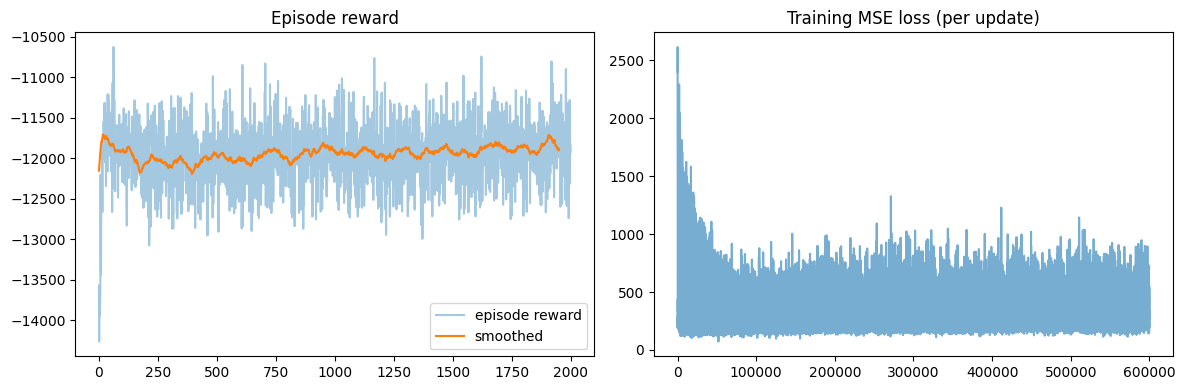

In [8]:
#8: Quick plots of reward and loss
# smooth reward
def smooth(x, w=50):
    if len(x) < w:
        return x
    return np.convolve(x, np.ones(w)/w, mode='valid')

# plot
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(reward_history, alpha=0.4, label='episode reward')
plt.plot(range(len(smooth(reward_history))), smooth(reward_history), label='smoothed')
plt.title("Episode reward")
plt.legend()

# plot loss
plt.subplot(1,2,2)
if loss_history: 
    plt.plot(loss_history, alpha=0.6) 
    plt.title("Training MSE loss (per update)")
else:
    plt.title("No loss data")
plt.tight_layout()
plt.show()


In [9]:
#9: Test the trained policy 
def test_policy(policy_model, episodes=10, render=True):
    policy_model.eval() # set model to eval mode
    results = [] 
    for ep in range(episodes):  # loop over episodes
        state, _ = env.reset()
        ep_reward = 0.0 # initialize episode reward
        for t in range(env.max_steps):
            with torch.no_grad():
                st = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0) # convert state to tensor
                action = int(policy_model(st).argmax().cpu().numpy()) # get action from policy model
            next_state, reward, terminated, truncated, info = env.step(action) # take action in environment
            ep_reward += reward #update episode reward
            if render: 
                print(f"\n Test Episode {ep+1} | Step {t+1}")
                env.render()
                print(f"Action chosen: {action}, Reward: {reward:.2f}")
            state = next_state #update state
            if terminated or truncated: #end episode
                break
        results.append(ep_reward) #store episode reward
        print(f"Test Episode {ep+1} finished | Total reward: {ep_reward:.2f}") 
    return results

#test
test_results = test_policy(policy_net, episodes=10, render=True) # test policy
print("Test episode rewards:", test_results)


c:\Users\siona\miniconda3\envs\myenv\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.max_steps to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.max_steps` for environment variables or `env.get_wrapper_attr('max_steps')` that will search the reminding wrappers.
  logger.warn(



 Test Episode 1 | Step 1
Step: 1
Raw Inventory: 1.0
Product Inventory Before Sale: 0.0, After Sale: 0.0
Raw Price: 4.57, Product Price: 20.00
Demand: 12.98, Cash: 995.11
Action chosen: 1, Reward: -65.02

 Test Episode 1 | Step 2
Step: 2
Raw Inventory: 2.0
Product Inventory Before Sale: 0.0, After Sale: 0.0
Raw Price: 4.38, Product Price: 19.82
Demand: 14.80, Cash: 990.54
Action chosen: 1, Reward: -74.19

 Test Episode 1 | Step 3
Step: 3
Raw Inventory: 3.0
Product Inventory Before Sale: 0.0, After Sale: 0.0
Raw Price: 4.21, Product Price: 19.82
Demand: 13.25, Cash: 986.15
Action chosen: 1, Reward: -66.55

 Test Episode 1 | Step 4
Step: 4
Raw Inventory: 4.0
Product Inventory Before Sale: 0.0, After Sale: 0.0
Raw Price: 4.13, Product Price: 19.53
Demand: 9.85, Cash: 981.94
Action chosen: 1, Reward: -49.65

 Test Episode 1 | Step 5
Step: 5
Raw Inventory: 2.0
Product Inventory Before Sale: 1.0, After Sale: 0.0
Raw Price: 4.02, Product Price: 19.66
Demand: 9.69, Cash: 1001.47
Action chosen:

Assignment asks for the questions to be put into a cell, does it mean code or markdown? I did markdown.

1. The biggest challenges I faced was unfortunately my laptop crashing every 45minutes(still troubleshooting it). But in regards to the assignment the challenges were balancing the exploration vs exploitation since the agnet needed enough exploration to find and discover new strategies, but not enough to hurt it later. Another issue which unfortunatley I couldn't solve we convergance time since the agent wouldve needed 5000+ episodes to converge and stabilize but the best option for me due to repeated crashing (BSOD) I had to settle with 2000 episodes. Some of the biggest takeaways were that the replay buffer is essential for stable learning in continuous state spaces. And also hyperparameter tuning (learning rate, epsilon decay, batch size) significantly impacts convergence speed and final performance.

2. Test episode rewards: [-19170.266300173225, -19233.410727232673, -19644.732391897807, -18759.322700504963, -19645.726727997888, -18228.70353537898, -20994.900863886534, -18807.14889567644, -19543.321920752976, -18997.846758776916]   
This shows that the training policy demonstrated learned behaviors in managing inventory under a changing market with prices and demand. Training showed convergence with the rewards improivng from -12,156 to -11,834 after 50 episodes and continued stabilizing. The mse loss decreased, and the rewards remained negative due to penaltiesbut the agent learned to minimize loess, while a training time to 5000 episodes would have likely improved preformace this was the best avaible solution for the time being.

3. Not in my feild (BSEE) but a cool application I see a lot of news on is that Proteins fold into 3D shapes that determine their function. And RL can try different folding patterns and reward closer matches to the real shape, helping predict structures fast. Knowing the shape helps scientists design drugs that fits which helps speed up the process. In my domain it could help find chemical compisitions to make and test for various types of battery electrodes, since there are so many different ratios of metals you can use with each varying and altering the output of what the battery could expereince in terms of mAH ,cycle life, and also charging rate. This would allow for more variety in batteries shortening the time to develop and test the most optimal ratios. 